In [138]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/EEG/'

import sys

from tensorflow.keras.layers import (
    Conv1D, Input, concatenate, GRU, Dense,
    BatchNormalization, Dropout, SeparableConv1D
)

import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import (
    SeparableConv1D, BatchNormalization, ReLU, Dropout, Dense,
    GlobalAveragePooling1D, LeakyReLU
)

sys.path.append('/content/drive/My Drive/EEG/')

from data.DataUtilEEG import DataUtilEEG
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.python.client import device_lib


from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Reshape,
    Multiply, DepthwiseConv2D, GlobalAveragePooling2D, LeakyReLU, ReLU, SeparableConv2D
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, classification_report
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.layers import SeparableConv1D, BatchNormalization, LeakyReLU, Dropout, GlobalAveragePooling1D, Dense,MaxPooling1D
from tensorflow.keras.regularizers import l1_l2

!pip install optuna
import optuna
!pip install optuna-integration[tfkeras]
from optuna.integration import TFKerasPruningCallback

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Detailed Device Information:")
print(device_lib.list_local_devices())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.18.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
Detailed Device Information:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17737313609384181791
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21985886208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17915833221926586777
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


**Priprava podatkov**

In [139]:
def augment_eeg_data_tf(X, y, noise_level=0.01, max_shift_steps=2, max_shift_factor=2, max_dropout_rate=0.05):
    p = .25

    def add_noise(data, noise_level):
        noise = tf.random.normal(shape=tf.shape(data), mean=0.0, stddev=noise_level)
        return data + noise

    def time_shift(data, max_shift_steps):
        shift_steps = tf.random.uniform([], minval=-max_shift_steps, maxval=max_shift_steps, dtype=tf.int32)
        return tf.roll(data, shift_steps, axis=1)

    def frequency_shift(data, max_shift_factor):
        fft_data = tf.signal.fft(tf.cast(data, tf.complex64))
        shift_factor = tf.random.uniform([], minval=-max_shift_factor, maxval=max_shift_factor, dtype=tf.int32)
        shifted_fft = tf.roll(fft_data, shift_factor, axis=1)
        return tf.math.real(tf.signal.ifft(shifted_fft))

    def electrode_dropout(data, max_dropout_rate):
        dropout_mask = tf.cast(tf.random.uniform(tf.shape(data)) >= max_dropout_rate, tf.float32)
        return data * dropout_mask

    def mirror_signal(data):
        return tf.reverse(data, axis=[1])

    def amplitude_flip(data):
        return data * -1.0
    X
    if tf.random.uniform([]) < p:
        X = add_noise(X, noise_level)
    if tf.random.uniform([]) < p:
        X = time_shift(X, max_shift_steps)
    if tf.random.uniform([]) < p:
        X = frequency_shift(X, max_shift_factor)
    if tf.random.uniform([]) < p:
        X = electrode_dropout(X, max_dropout_rate)
    if tf.random.uniform([]) < p:
        X = mirror_signal(X)
    if tf.random.uniform([]) < p:
        X = amplitude_flip(X)

    return X, y



def plot_history(history):
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    axs[0].plot(history.history['loss'],
                label='Training Loss',
                color=sns.color_palette("tab10")[0],
                marker='o',
                linewidth=2,
                markersize=6)

    axs[0].plot(history.history['val_loss'],
                label='Validation Loss',
                color=sns.color_palette("tab10")[1],
                marker='s',
                linewidth=2,
                markersize=6,
                linestyle='--')

    axs[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
    axs[0].set_xlabel('Epochs', fontsize=12, labelpad=10)
    axs[0].set_ylabel('Loss', fontsize=12, labelpad=10)
    axs[0].legend(loc="best", fontsize=10, frameon=True, facecolor='white', edgecolor='gray', shadow=True)
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].tick_params(labelsize=10)

    axs[1].plot(history.history['accuracy'],
                label='Training Accuracy',
                color=sns.color_palette("tab10")[2],
                marker='o',
                linewidth=2,
                markersize=6)

    axs[1].plot(history.history['val_accuracy'],
                label='Validation Accuracy',
                color=sns.color_palette("tab10")[3],
                marker='s',
                linewidth=2,
                markersize=6,
                linestyle='--')

    axs[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
    axs[1].set_xlabel('Epochs', fontsize=12, labelpad=10)
    axs[1].set_ylabel('Accuracy', fontsize=12, labelpad=10)
    axs[1].legend(loc="best", fontsize=10, frameon=True, facecolor='white', edgecolor='gray', shadow=True)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()



def plot_history_from_dict(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()




In [140]:
processor = DataUtilEEG(path + 'data/Final_ALLEEG_datasets_Coffe.mat')

processor.load_data()

processor.process_data()

processor.split_data(test_size=0.3, val_size=0.2, shuffle=True)

processor.get_summary()

processor.create_tf_datasets()

class_weights = processor.get_class_weights()



Train shape: (1856, 1260, 32), Val shape: (743, 1260, 32), Test shape: (1114, 1260, 32)
Class weights: {0: 1.0065075921908895, 1: 0.9935760171306209}
Train: 1856 samples, Val: 743 samples, Test: 1114 samples


In [141]:
BATCH = 64

train_dataset = processor.train_dataset

train_dataset_augment_0 = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)


train_dataset_augment_5 = (
    train_dataset
    .shuffle(buffer_size=1000)
    .repeat(5)
    .map(augment_eeg_data_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset_augment_10 = (
    train_dataset
    .shuffle(buffer_size=1000)
    .repeat(10)
    .map(augment_eeg_data_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset_augment_20 = (
    train_dataset
    .shuffle(buffer_size=1000)
    .repeat(20)
    .map(augment_eeg_data_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)


val_dataset = (
     processor.val_dataset
    .shuffle(buffer_size=1000)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    processor.val_dataset
    .shuffle(buffer_size=1000)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [142]:
for x, y in val_dataset.take(1):
    print("train_dataset_augment_20 shape:", x.shape, y.shape)

train_dataset_augment_20 shape: (64, 1260, 32) (64,)


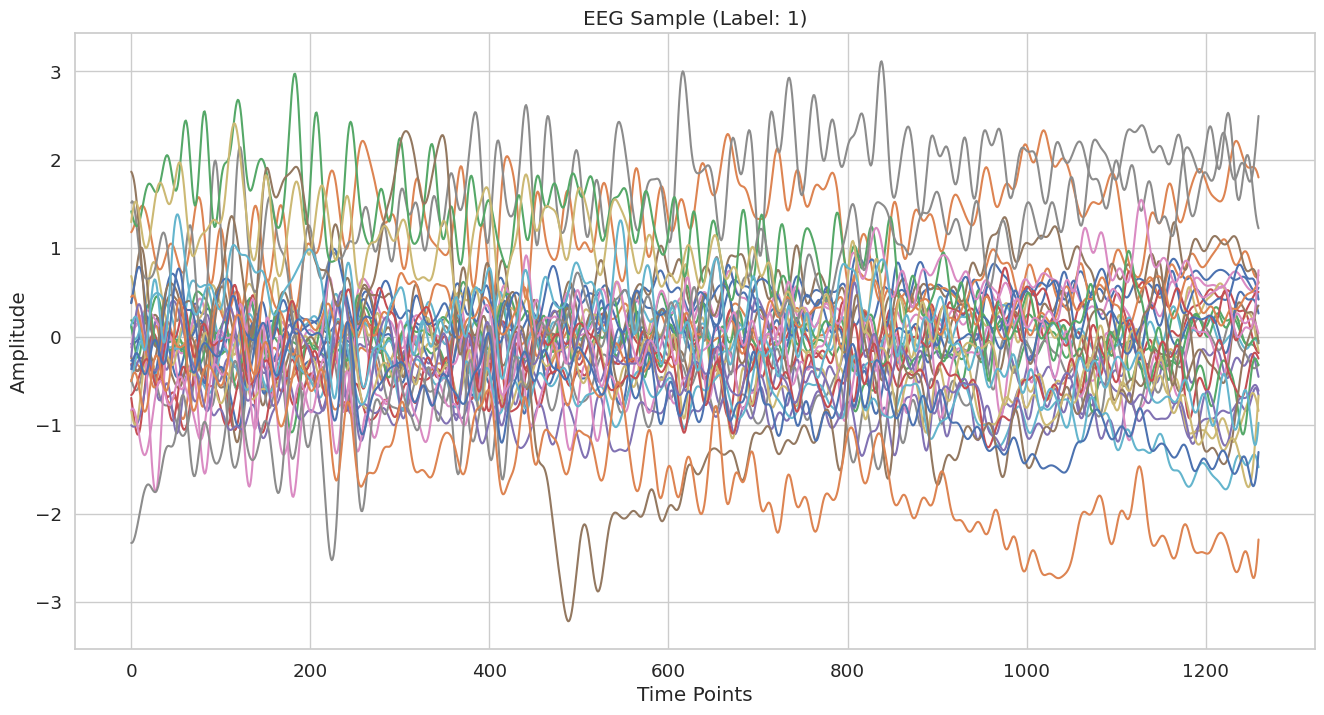

In [171]:
for batch in train_dataset_augment_0.take(1):
    X_batch, y_batch = batch
    break

X_sample = X_batch[0].numpy()
y_sample = y_batch[0].numpy()

plt.figure(figsize=(16, 8))
for i in range(X_sample.shape[1]):
    plt.plot(X_sample[:, i], label=f'Channel {i+1}')

plt.title(f"EEG Sample (Label: {y_sample})")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
#plt.legend(loc="upper right", ncol=2, fontsize='small')
plt.grid(True)
plt.show()


**TESTIRANJE VPLIVA AUGMENTACIJE**

In [144]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.65, patience=5, verbose=0)
max_epoch=100

In [145]:
def build_1d_cnn(input_shape, num_classes=1, learning_rate=0.001, dropout_rate=0.4, l1=1e-6, l2=1e-4, negative_slope=0.01):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = Conv1D(filters=16, kernel_size=5, padding="same", activation=None,
               kernel_initializer="he_normal", kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)
    x = MaxPooling1D(pool_size=4)(x)  # Helps generalization

    # Conv Block 2
    x = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
               kernel_initializer="he_normal", kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)
    x = MaxPooling1D(pool_size=4)(x)

    # Conv Block 3 Depthwise Separable
    x = SeparableConv1D(filters=64, kernel_size=7, padding="same", activation=None,
                         depthwise_initializer="he_normal", pointwise_initializer="he_normal",
                         depthwise_regularizer=l1_l2(l1=l1, l2=l2), pointwise_regularizer=l1_l2(l1=l1, l2=l2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)
    x = MaxPooling1D(pool_size=4)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy", metrics=["accuracy"])

    return model


AUGMENT 0


In [ ]:
def objective(trial):
    drop_rate = trial.suggest_float("drop_rate", 0.1, 0.5)  # Dropout
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # LR
    l1 = trial.suggest_float("l1", 1e-9, 1e-3, log=True)  # L1 Regularization
    l2 = trial.suggest_float("l2", 1e-9, 1e-3, log=True)  # L2 Regularization
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)  # Leaky ReLU negative slope

    model = build_1d_cnn(
        input_shape=(1260, 32),
        dropout_rate=drop_rate,
        learning_rate=learning_rate,
        l1=l1,
        l2=l2,
        negative_slope=alpha,
    )

    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")


    history = model.fit(
        train_dataset_augment_0,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[early_stopping, reduce_lr, pruning_callback],
        verbose=0,
    )

    best_val_acc = max(history.history["val_accuracy"])
    return best_val_acc


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50)

best_params_customizable_1d_cnn_rnn_attention = study.best_params
print("Best Hyperparameters:", best_params_customizable_1d_cnn_rnn_attention)


[I 2025-02-04 10:39:05,284] A new study created in memory with name: no-name-1c53c685-487a-4521-ae61-96b48d126ed8
[I 2025-02-04 10:39:19,479] Trial 0 finished with value: 0.7286931872367859 and parameters: {'drop_rate': 0.23537713522593318, 'learning_rate': 0.0025656287028394367, 'l1': 0.00020174219179024347, 'l2': 1.5172801044670287e-07, 'alpha': 0.0008332787822389184}. Best is trial 0 with value: 0.7286931872367859.
[I 2025-02-04 10:39:28,431] Trial 1 finished with value: 0.5284090638160706 and parameters: {'drop_rate': 0.1281445447534568, 'learning_rate': 2.0751041193925656e-05, 'l1': 1.6202403299260495e-06, 'l2': 1.2975115116518503e-05, 'alpha': 0.06779723226365493}. Best is trial 0 with value: 0.7286931872367859.
[I 2025-02-04 10:39:43,031] Trial 2 finished with value: 0.7798295617103577 and parameters: {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}. Best is trial 2

Best Hyperparameters: {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}


In [146]:
params = {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}

model_customizable_1d_cnn_augment_0 = build_1d_cnn(
    input_shape=(1260, 32),
    dropout_rate=params['drop_rate'],
    learning_rate=params['learning_rate'],
    l1=params['l1'],
    l2=params['l2'],
    negative_slope=params['alpha'],
)

history_model_customizable_1d_cnn_augment_0 = model_customizable_1d_cnn_augment_0.fit(
    train_dataset_augment_0,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    class_weight=None,
    verbose=1
)

# test
test_loss, test_accuracy = model_customizable_1d_cnn_augment_0.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/augmentacija_CNN_vpliv'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_1d_cnn_augment_0.keras')
model_customizable_1d_cnn_augment_0.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_1d_cnn_augment_0.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_customizable_1d_cnn_augment_0.history, file)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5096 - loss: 0.8166 - val_accuracy: 0.5710 - val_loss: 0.7251 - learning_rate: 0.0035
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5679 - loss: 0.7326 - val_accuracy: 0.5781 - val_loss: 0.7128 - learning_rate: 0.0035
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6015 - loss: 0.6923 - val_accuracy: 0.6151 - val_loss: 0.6966 - learning_rate: 0.0035
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6152 - loss: 0.6750 - val_accuracy: 0.6548 - val_loss: 0.6835 - learning_rate: 0.0035
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6731 - loss: 0.6258 - val_accuracy: 0.6435 - val_loss: 0.6645 - learning_rate: 0.0035
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6818 - loss: 0.6240 - val_accuracy: 0.6733 - val_loss: 0.6531 - learning_rate: 0.0035
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7118 - loss: 0.5881 - val_ac

AUGMENT 5  


In [147]:
params = {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}

model_customizable_1d_cnn_augment_5 = build_1d_cnn(
    input_shape=(1260, 32),
    dropout_rate=params['drop_rate'],
    learning_rate=params['learning_rate'],
    l1=params['l1'],
    l2=params['l2'],
    negative_slope=params['alpha']
)

history_model_customizable_1d_cnn_augment_5 = model_customizable_1d_cnn_augment_5.fit(
    train_dataset_augment_5,
    validation_data=val_dataset,
    epochs=max_epoch,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# test
test_loss, test_accuracy = model_customizable_1d_cnn_augment_5.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/augmentacija_CNN_vpliv'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_1d_cnn_augment_5.keras')
model_customizable_1d_cnn_augment_5.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_1d_cnn_augment_5.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_customizable_1d_cnn_augment_5.history, file)


Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5105 - loss: 0.7985 - val_accuracy: 0.5341 - val_loss: 0.7214 - learning_rate: 0.0035
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5364 - loss: 0.7381 - val_accuracy: 0.6094 - val_loss: 0.6887 - learning_rate: 0.0035
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5765 - loss: 0.7149 - val_accuracy: 0.5966 - val_loss: 0.7130 - learning_rate: 0.0035
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5957 - loss: 0.6994 - val_accuracy: 0.6619 - val_loss: 0.6651 - learning_rate: 0.0035
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5923 - loss: 0.6913 - val_accuracy: 0.6307 - val_loss: 0.6581 - learning_rate: 0.0035
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6177 - loss: 0.6811 - val_accuracy: 0.6662 - val_loss: 0.6350 - learning_rate: 0.0035
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6160 - loss: 0

AUGMENT 10   

In [148]:
params = {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}

model_customizable_1d_cnn_augment_10 = build_1d_cnn(
    input_shape=(1260, 32),
    dropout_rate=params['drop_rate'],
    learning_rate=params['learning_rate'],
    l1=params['l1'],
    l2=params['l2'],
    negative_slope=params['alpha']
)

history_model_customizable_1d_cnn_augment_10 = model_customizable_1d_cnn_augment_10.fit(
    train_dataset_augment_10,
    validation_data=val_dataset,
    epochs=max_epoch,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# test
test_loss, test_accuracy = model_customizable_1d_cnn_augment_10.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/augmentacija_CNN_vpliv'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_1d_cnn_augment_10.keras')
model_customizable_1d_cnn_augment_10.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_1d_cnn_augment_10.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_customizable_1d_cnn_augment_10.history, file)


Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5264 - loss: 0.7840 - val_accuracy: 0.5724 - val_loss: 0.7114 - learning_rate: 0.0035
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5868 - loss: 0.7049 - val_accuracy: 0.6435 - val_loss: 0.6705 - learning_rate: 0.0035
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6146 - loss: 0.6856 - val_accuracy: 0.6719 - val_loss: 0.6476 - learning_rate: 0.0035
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6295 - loss: 0.6674 - val_accuracy: 0.6619 - val_loss: 0.6352 - learning_rate: 0.0035
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6352 - loss: 0.6573 - val_accuracy: 0.6562 - val_loss: 0.6250 - learning_rate: 0.0035
Epoch 6/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6445 - loss: 0.6529 - val_accuracy: 0.6747 - val_loss: 0.6339 - learning_rate: 0.0035
Epoch 7/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6533 - loss: 0.

AUGMENT 20

In [149]:
params = {'drop_rate': 0.3442030046903568, 'learning_rate': 0.0035377572154143264, 'l1': 3.893736809025823e-05, 'l2': 1.3690593503540857e-06, 'alpha': 0.013129881412733638}


# Gradnja modela
model_customizable_1d_cnn_augment_20 = build_1d_cnn(
    input_shape=(1260, 32),
    dropout_rate=params['drop_rate'],
    learning_rate=params['learning_rate'],
    l1=params['l1'],
    l2=params['l2'],
    negative_slope=params['alpha']
)

# Treniranje modela
history_model_customizable_1d_cnn_augment_20 = model_customizable_1d_cnn_augment_20.fit(
    train_dataset_augment_20,
    validation_data=val_dataset,
    epochs=max_epoch,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluacija modela
test_loss, test_accuracy = model_customizable_1d_cnn_augment_20.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Ustvarjanje direktorija za shranjevanje modela
save_dir = '/content/drive/My Drive/EEG/models/augmentacija_CNN_vpliv'
os.makedirs(save_dir, exist_ok=True)

# Shranjevanje modela
model_path = os.path.join(save_dir, 'model_customizable_1d_cnn_augment_20.keras')
model_customizable_1d_cnn_augment_20.save(model_path)

# Shranjevanje zgodovine učenja modela
history_path = os.path.join(save_dir, 'history_model_customizable_1d_cnn_augment_20.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history_model_customizable_1d_cnn_augment_20.history, file)


Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5382 - loss: 0.7537 - val_accuracy: 0.6023 - val_loss: 0.6825 - learning_rate: 0.0035
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6154 - loss: 0.6832 - val_accuracy: 0.6946 - val_loss: 0.6045 - learning_rate: 0.0035
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6501 - loss: 0.6468 - val_accuracy: 0.6918 - val_loss: 0.6007 - learning_rate: 0.0035
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6739 - loss: 0.6205 - val_accuracy: 0.7159 - val_loss: 0.5694 - learning_rate: 0.0035
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6928 - loss: 0.6018 - val_accuracy: 0.7642 - val_loss: 0.5107 - learning_rate: 0.0035
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7147 - loss: 0.5736 - val_accuracy: 0.7358 - val_loss: 0.5407 - learning_rate: 0.0035
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7289 - loss: 0.

PRIMERJAVA MODELOV Z RAZLIČNO AUGMENTACIJO

In [150]:
save_dir = '/content/drive/My Drive/EEG/models/augmentacija_CNN_vpliv'
augmentations = [0, 5, 10, 20]

models = {}
histories = {}

for aug in augmentations:
    model_path = os.path.join(save_dir, f'model_customizable_1d_cnn_augment_{aug}.keras')
    history_path = os.path.join(save_dir, f'history_model_customizable_1d_cnn_augment_{aug}.pkl')

    if os.path.exists(model_path):
        models[f"model_customizable_1d_cnn_augment_{aug}"] = tf.keras.models.load_model(model_path)
        print(f"Naložen model: model_customizable_1d_cnn_augment_{aug}")
    else:
        print(f"Model {model_path} ne obstaja!")

    if os.path.exists(history_path):
        with open(history_path, "rb") as file:
            histories[f"history_model_customizable_1d_cnn_augment_{aug}"] = pickle.load(file)
        print(f"Naložena zgodovina: history_model_customizable_1d_cnn_augment_{aug}")
    else:
        print(f"Zgodovina {history_path} ne obstaja!")


Naložen model: model_customizable_1d_cnn_augment_0
Naložena zgodovina: history_model_customizable_1d_cnn_augment_0
Naložen model: model_customizable_1d_cnn_augment_5
Naložena zgodovina: history_model_customizable_1d_cnn_augment_5
Naložen model: model_customizable_1d_cnn_augment_10
Naložena zgodovina: history_model_customizable_1d_cnn_augment_10
Naložen model: model_customizable_1d_cnn_augment_20
Naložena zgodovina: history_model_customizable_1d_cnn_augment_20


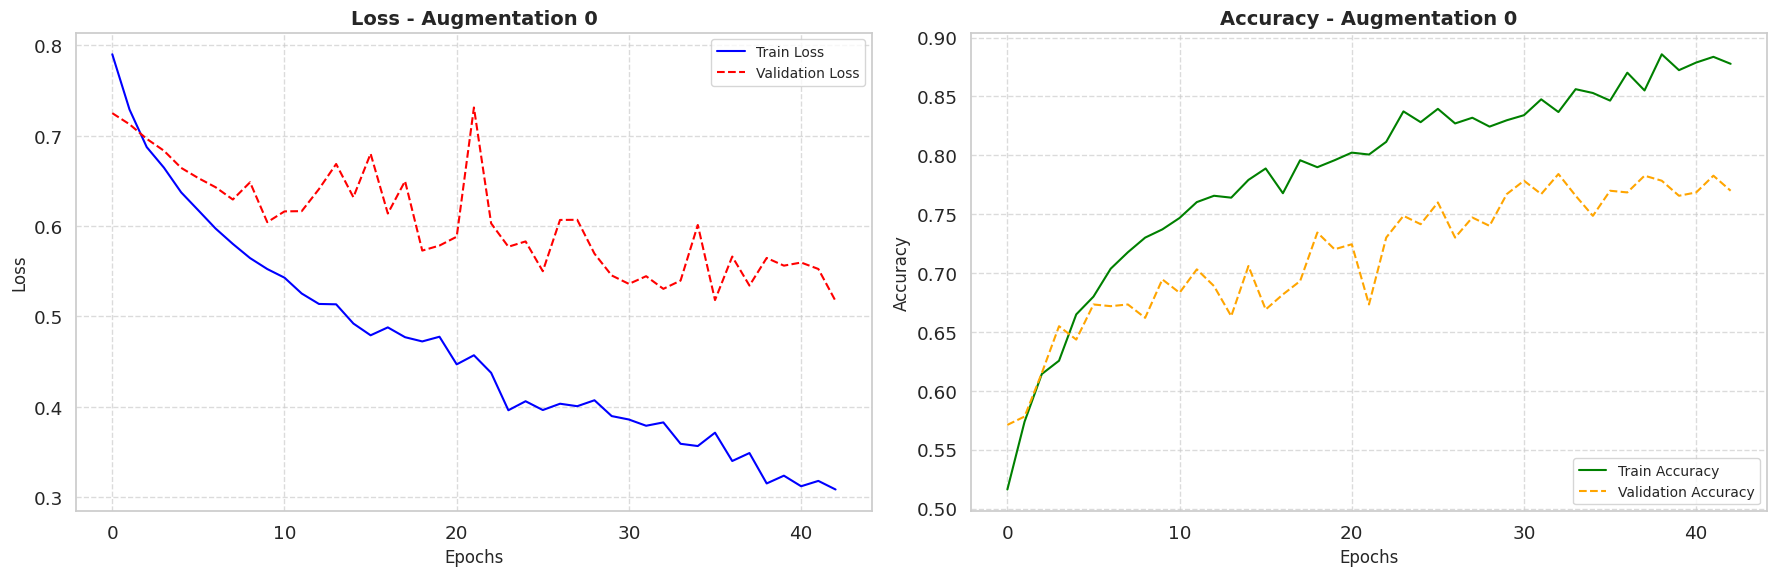

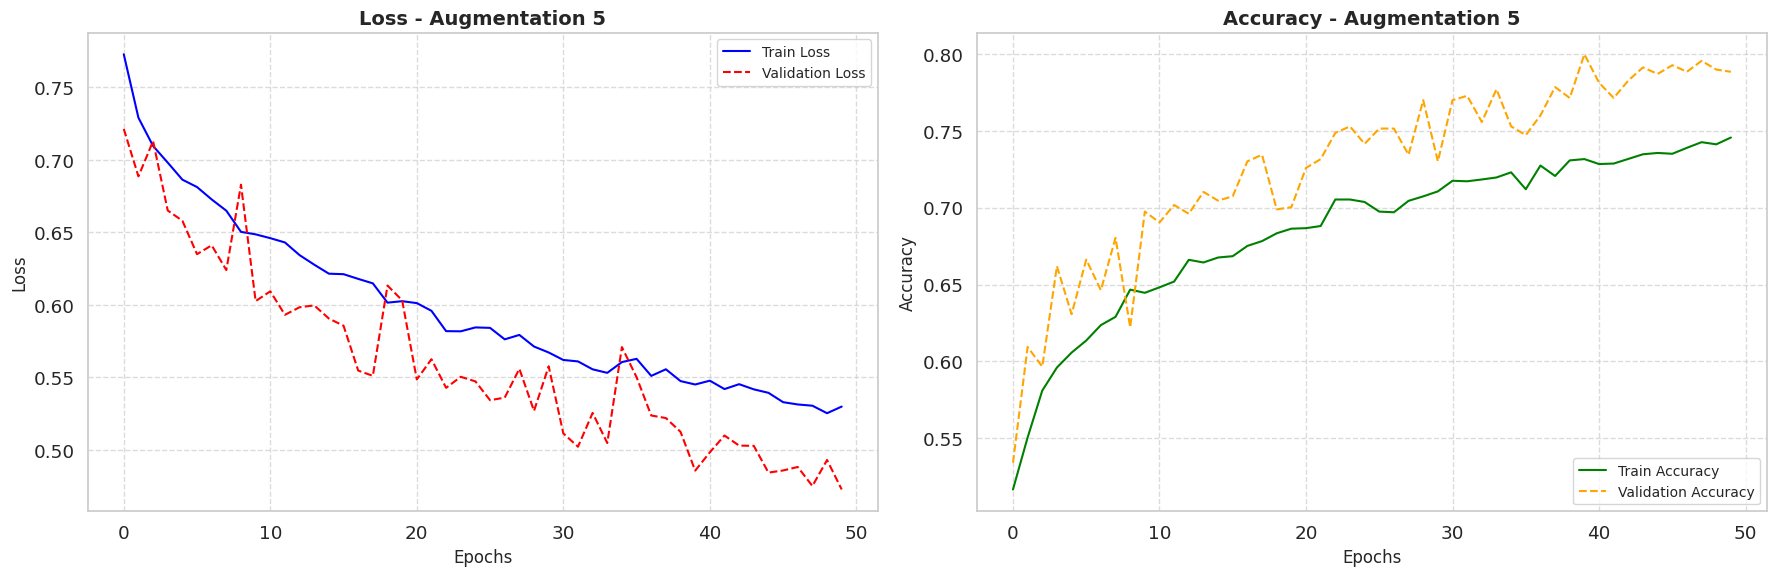

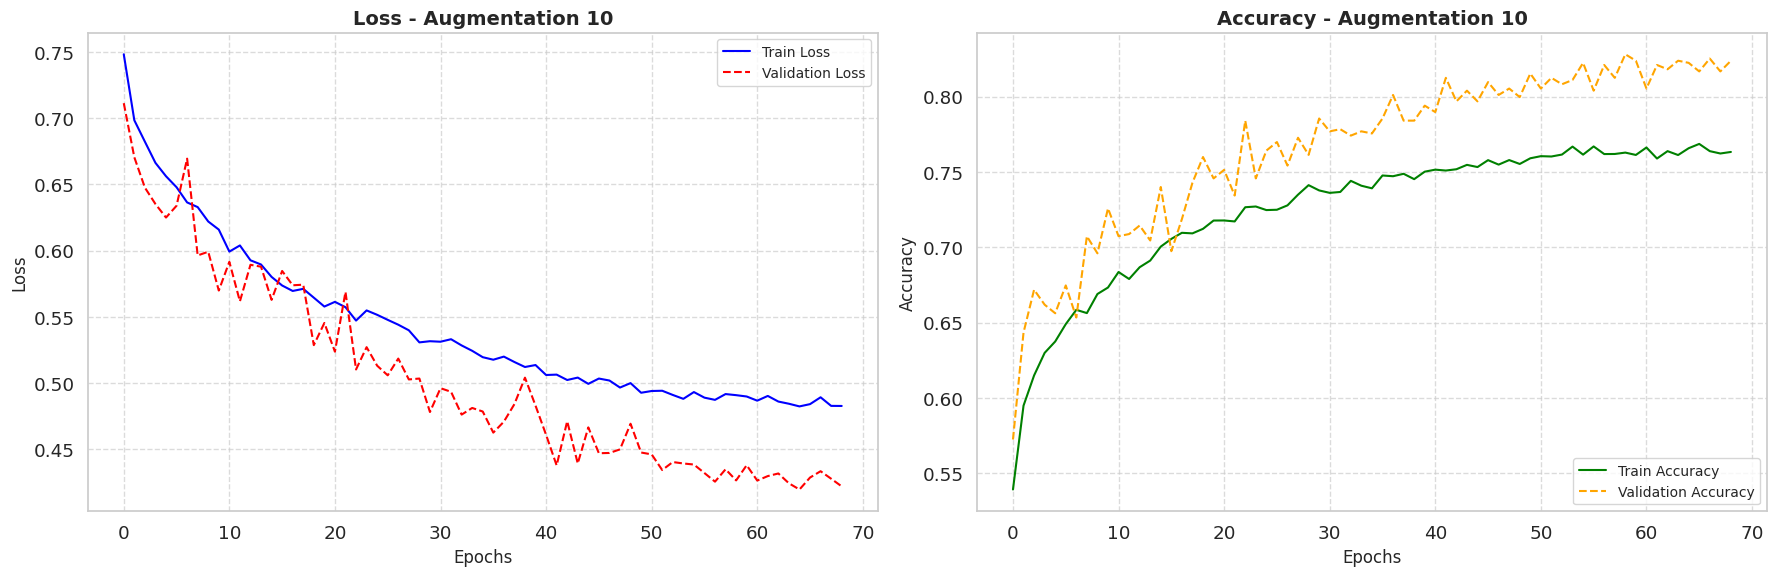

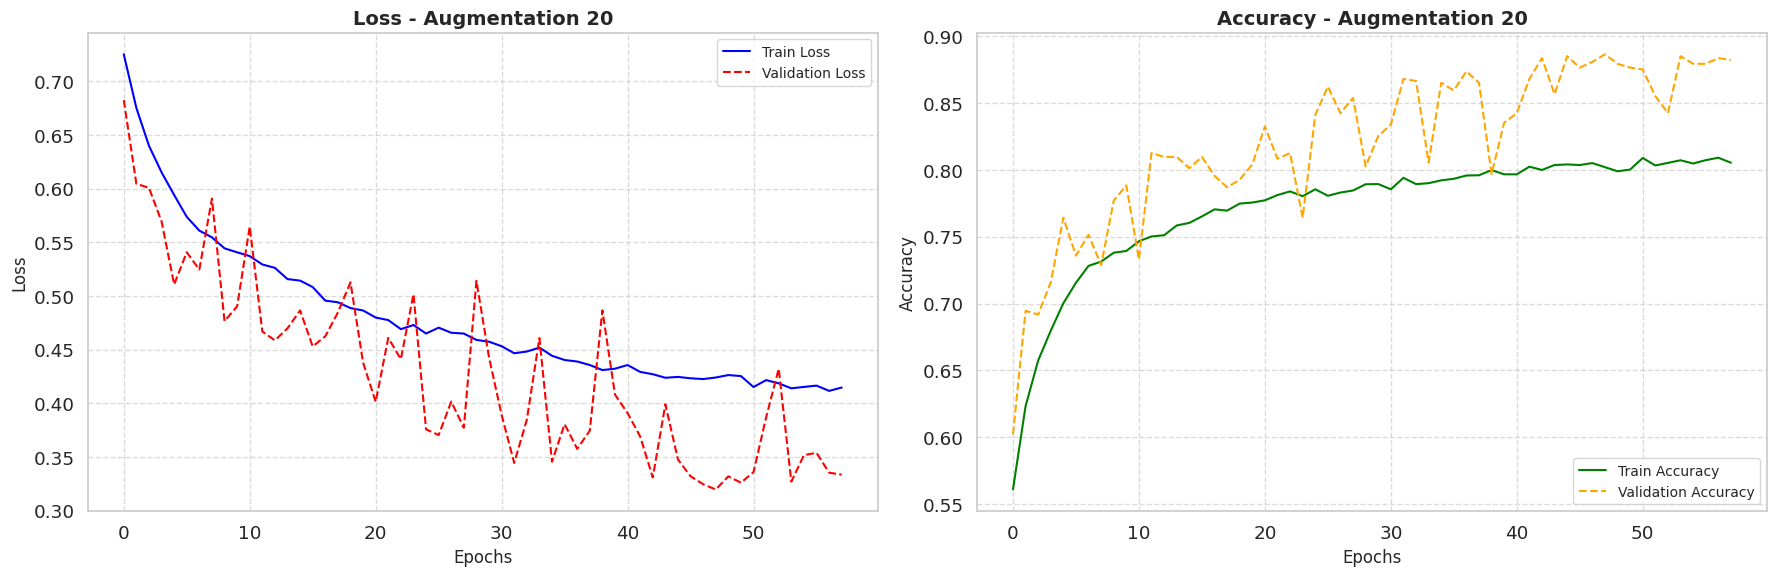

In [151]:

augmentations = [0, 5, 10, 20]

colors = sns.color_palette("tab10", len(augmentations))
line_styles = ['-', '--', '-.', ':']

def plot_individual_histories():
    for aug in augmentations:
        history_var = f"history_model_customizable_1d_cnn_augment_{aug}"

        if history_var in globals():
            history = globals()[history_var].history
        else:
            print(f"{history_var} ne obstaja, preskakujem...")
            continue

        fig, axs = plt.subplots(1, 2, figsize=(18, 6))

        # Loss subplot
        sns.lineplot(x=range(len(history['loss'])), y=history['loss'], label='Train Loss', color='blue', linestyle='-', ax=axs[0])
        sns.lineplot(x=range(len(history['val_loss'])), y=history['val_loss'], label='Validation Loss', color='red', linestyle='--', ax=axs[0])

        axs[0].set_title(f'Loss - Augmentation {aug}', fontsize=14, fontweight='bold')
        axs[0].set_xlabel('Epochs', fontsize=12)
        axs[0].set_ylabel('Loss', fontsize=12)
        axs[0].legend(loc="upper right", fontsize=10)
        axs[0].grid(True, linestyle='--', alpha=0.7)

        # Accuracy subplot
        sns.lineplot(x=range(len(history['accuracy'])), y=history['accuracy'], label='Train Accuracy', color='green', linestyle='-', ax=axs[1])
        sns.lineplot(x=range(len(history['val_accuracy'])), y=history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', ax=axs[1])

        axs[1].set_title(f'Accuracy - Augmentation {aug}', fontsize=14, fontweight='bold')
        axs[1].set_xlabel('Epochs', fontsize=12)
        axs[1].set_ylabel('Accuracy', fontsize=12)
        axs[1].legend(loc="lower right", fontsize=10)
        axs[1].grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()


plot_individual_histories()

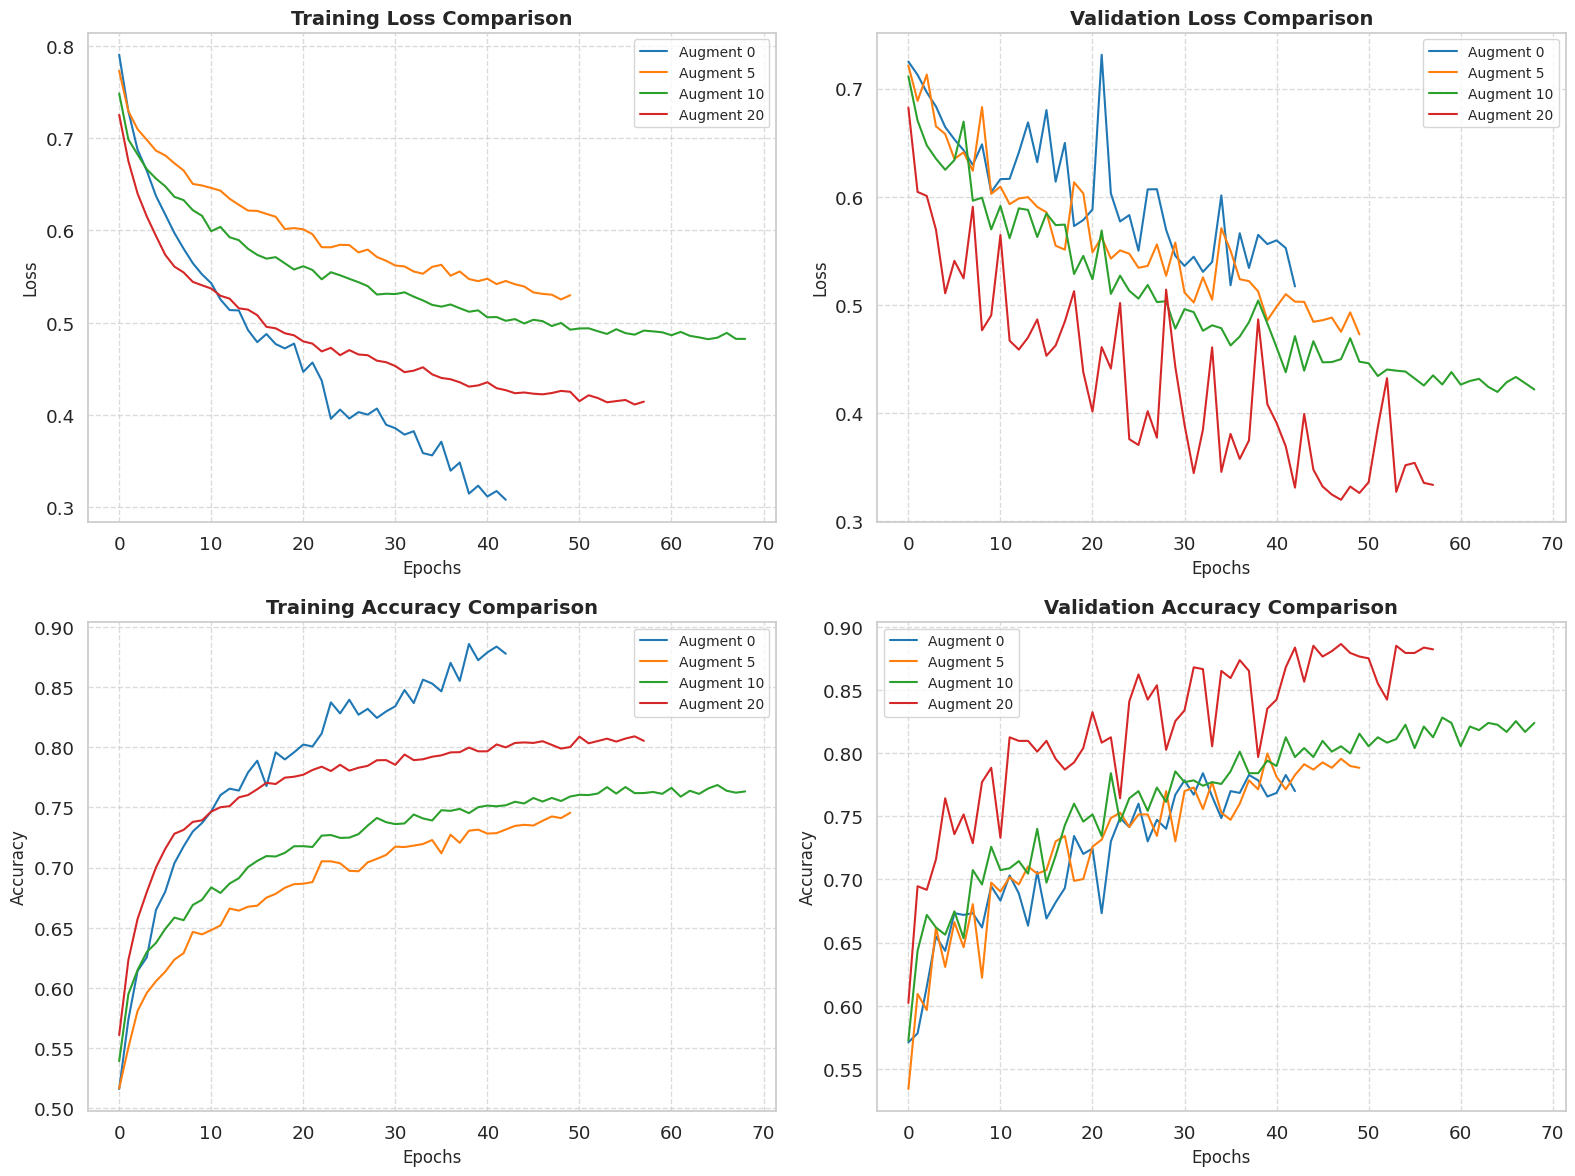

In [152]:

augmentations = [0, 5, 10, 20]

colors = sns.color_palette("tab10", len(augmentations))

def plot_separate_comparisons():
    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for idx, aug in enumerate(augmentations):
        history_var = f"history_model_customizable_1d_cnn_augment_{aug}"

        if history_var in globals():
            history = globals()[history_var].history
        else:
            print(f"{history_var} ne obstaja, preskakujem...")
            continue

        axs[0, 0].plot(history['loss'], label=f'Augment {aug}', color=colors[idx])

        axs[0, 1].plot(history['val_loss'], label=f'Augment {aug}', color=colors[idx])

        axs[1, 0].plot(history['accuracy'], label=f'Augment {aug}', color=colors[idx])


        axs[1, 1].plot(history['val_accuracy'], label=f'Augment {aug}', color=colors[idx])

    axs[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
    axs[0, 0].set_xlabel('Epochs', fontsize=12)
    axs[0, 0].set_ylabel('Loss', fontsize=12)
    axs[0, 0].legend(loc="best", fontsize=10)
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    axs[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axs[0, 1].set_xlabel('Epochs', fontsize=12)
    axs[0, 1].set_ylabel('Loss', fontsize=12)
    axs[0, 1].legend(loc="best", fontsize=10)
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    axs[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
    axs[1, 0].set_xlabel('Epochs', fontsize=12)
    axs[1, 0].set_ylabel('Accuracy', fontsize=12)
    axs[1, 0].legend(loc="best", fontsize=10)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    axs[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axs[1, 1].set_xlabel('Epochs', fontsize=12)
    axs[1, 1].set_ylabel('Accuracy', fontsize=12)
    axs[1, 1].legend(loc="best", fontsize=10)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_separate_comparisons()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7831 - loss: 0.5240
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8232 - loss: 0.4781
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8140 - loss: 0.4454
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8866 - loss: 0.3197


<ipython-input-153-815654e345a7>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_losses.keys()), y=list(test_losses.values()), ax=axs[0], palette="Blues")
<ipython-input-153-815654e345a7>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_accuracies.keys()), y=list(test_accuracies.values()), ax=axs[1], palette="Greens")


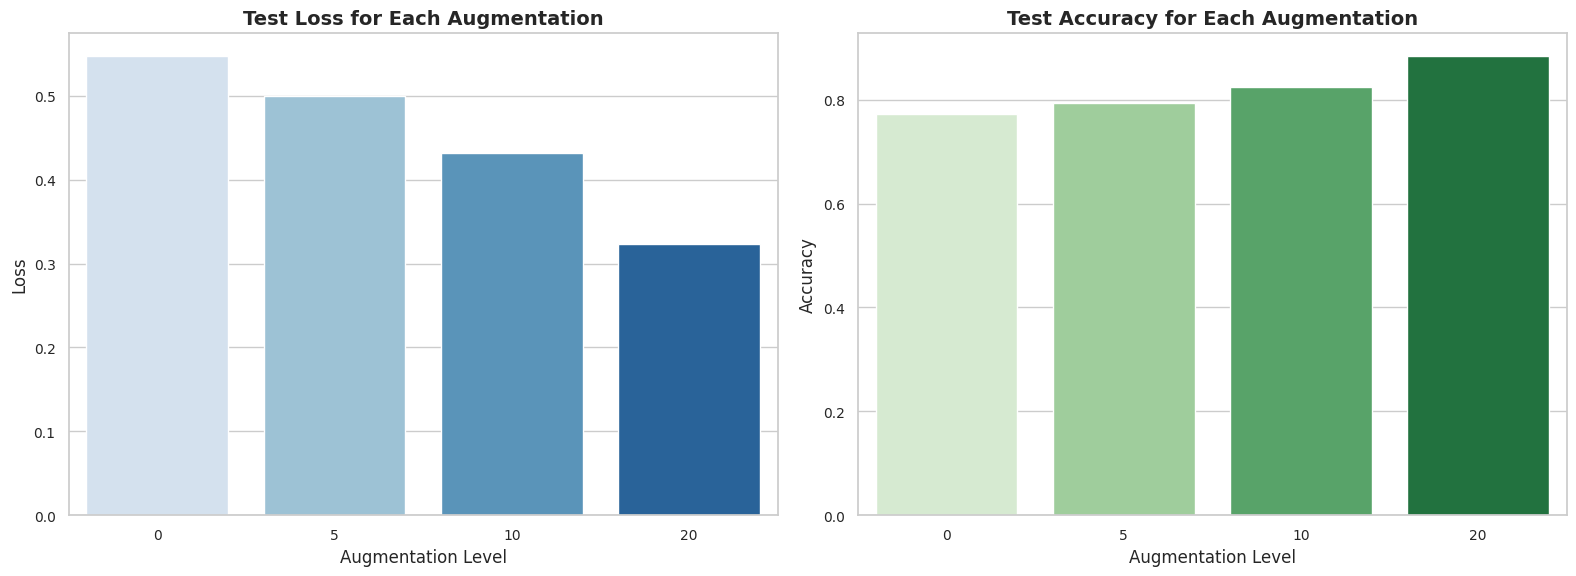

In [153]:
augmentations = [0, 5, 10, 20]

test_losses = {}
test_accuracies = {}

for aug in augmentations:
    model_var_name = f"model_customizable_1d_cnn_augment_{aug}"

    if model_var_name in globals():
        model = globals()[model_var_name]
        # TESTNI PODATKI - PREDICT
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

        test_losses[aug] = test_loss
        test_accuracies[aug] = test_accuracy
    else:
        print(f"Model {model_var_name} ni naložen!")

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Loss graf
sns.barplot(x=list(test_losses.keys()), y=list(test_losses.values()), ax=axs[0], palette="Blues")
axs[0].set_title("Test Loss for Each Augmentation", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Augmentation Level", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].tick_params(labelsize=10)

# Accuracy graf
sns.barplot(x=list(test_accuracies.keys()), y=list(test_accuracies.values()), ax=axs[1], palette="Greens")
axs[1].set_title("Test Accuracy for Each Augmentation", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Augmentation Level", fontsize=12)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].tick_params(labelsize=10)

plt.tight_layout()
plt.show()


MODELI

Convolution NN

In [154]:
def build_customizable_1d_cnn(input_shape, num_classes=1, learning_rate=0.001, dropout_rate=0.3, l1=1e-6, l2=1e-4, negative_slope=0.01):
    inputs = tf.keras.Input(shape=input_shape)

    x = SeparableConv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        depthwise_initializer=tf.keras.initializers.HeNormal(seed=42),
        depthwise_regularizer=l1_l2(l1=l1, l2=l2),
        pointwise_regularizer=l1_l2(l1=l1, l2=l2)
    )(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)

    x = SeparableConv1D(
        filters=32,
        kernel_size=5,
        padding="same",
        depthwise_initializer=tf.keras.initializers.HeNormal(seed=42),
        depthwise_regularizer=l1_l2(l1=l1, l2=l2),
        pointwise_regularizer=l1_l2(l1=l1, l2=l2)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)

    x = SeparableConv1D(
        filters=64,
        kernel_size=5,
        padding="same",
        depthwise_initializer=tf.keras.initializers.HeNormal(seed=42),
        depthwise_regularizer=l1_l2(l1=l1, l2=l2),
        pointwise_regularizer=l1_l2(l1=l1, l2=l2)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)

    x = SeparableConv1D(
        filters=128,
        kernel_size=7,
        padding="same",
        depthwise_initializer=tf.keras.initializers.HeNormal(seed=42),
        depthwise_regularizer=l1_l2(l1=l1, l2=l2),
        pointwise_regularizer=l1_l2(l1=l1, l2=l2)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)

    x = Dropout(dropout_rate)(x)

    x = SeparableConv1D(
        filters=256,
        kernel_size=7,
        padding="same",
        depthwise_initializer=tf.keras.initializers.HeNormal(seed=42),
        depthwise_regularizer=l1_l2(l1=l1, l2=l2),
        pointwise_regularizer=l1_l2(l1=l1, l2=l2)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=negative_slope)(x)

    x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [155]:
model = build_customizable_1d_cnn(
    input_shape=(1260, 32),
    num_classes=1,
    learning_rate=0.0035977753522713324,
    dropout_rate=0.2410385984341462,
    l1= 1.9469882296807997e-07,
    l2=7.578607880459829e-06,
    negative_slope=0.09218023336511874
)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_dataset_augment_20,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.5356 - loss: 0.7093 - val_accuracy: 0.5682 - val_loss: 0.6883 - learning_rate: 0.0036
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6019 - loss: 0.6607 - val_accuracy: 0.6491 - val_loss: 0.6311 - learning_rate: 0.0036
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6279 - loss: 0.6439 - val_accuracy: 0.6051 - val_loss: 0.6694 - learning_rate: 0.0036
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6384 - loss: 0.6330 - val_accuracy: 0.6889 - val_loss: 0.5890 - learning_rate: 0.0036
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6535 - loss: 0.6144 - val_accuracy: 0.7060 - val_loss: 0.5787 - learning_rate: 0.0036
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6548 - loss: 0.6107 - val_accuracy: 0.6847 - val_loss: 0.5998 - learning_rate: 0.0036
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.6

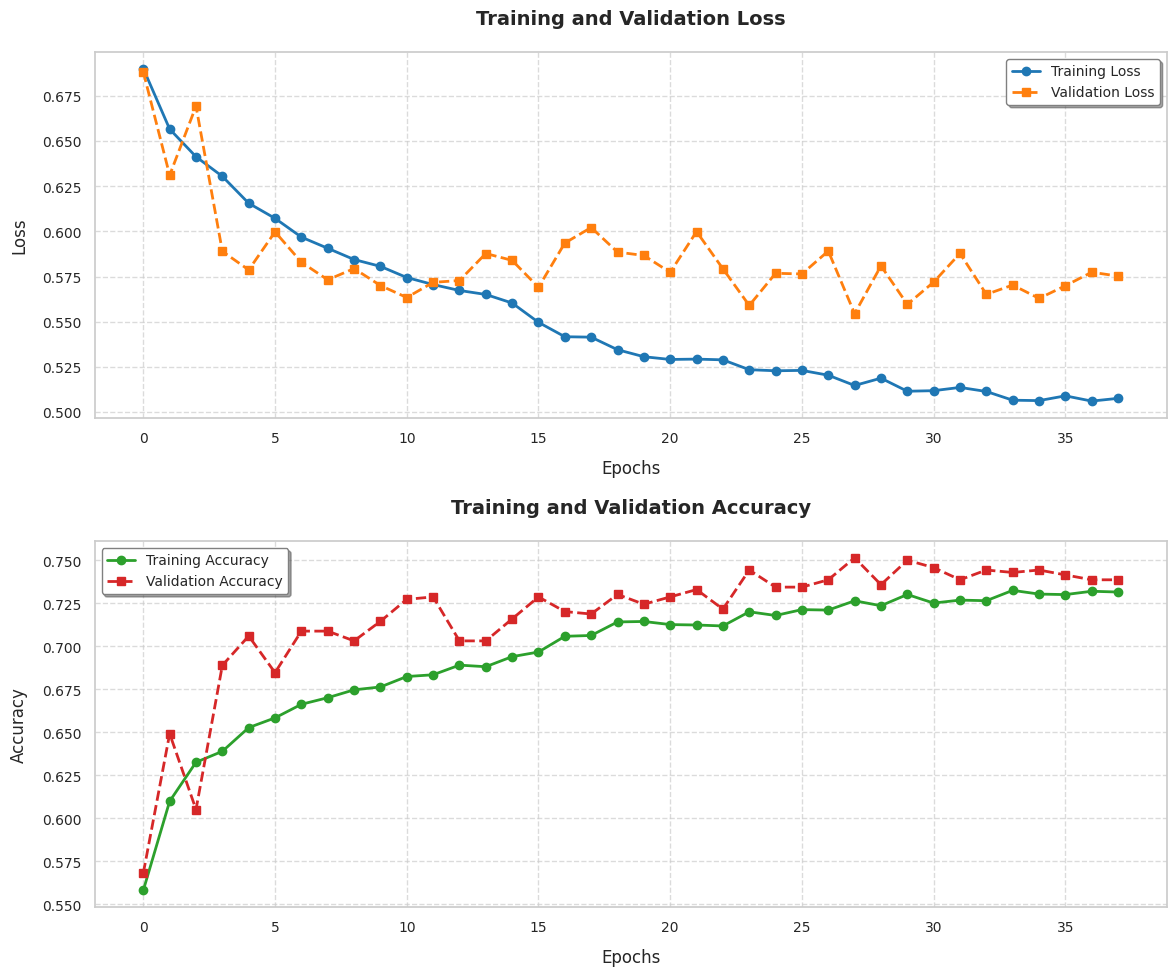

In [156]:
plot_history(history)

In [157]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/modeli_klasifikacija'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_1d_cnn_main.keras')
model.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_1d_cnn_main.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history.history, file)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7401 - loss: 0.5539
Test Loss: 0.5483334064483643
Test Accuracy: 0.7414772510528564


**Convolution + Reccurant**

In [158]:
def build_custom_chrononet(input_shape,
                           num_classes=1,
                           learning_rate=0.001,
                           dropout_rate=0.3,
                           l1=1e-6,
                           l2=1e-4):

    def block(input_layer):
        conv1 = Conv1D(filters=32, kernel_size=2, strides=2, activation="relu",
                       padding="causal",
                       kernel_initializer=HeNormal(),
                       kernel_regularizer=l1_l2(l1=l1, l2=l2))(input_layer)
        conv2 = Conv1D(filters=32, kernel_size=4, strides=2, activation="relu",
                       padding="causal",
                       kernel_initializer=HeNormal(),
                       kernel_regularizer=l1_l2(l1=l1, l2=l2))(input_layer)
        conv3 = Conv1D(filters=32, kernel_size=8, strides=2, activation="relu",
                       padding="causal",
                       kernel_initializer=HeNormal(),
                       kernel_regularizer=l1_l2(l1=l1, l2=l2))(input_layer)

        x = concatenate([conv1, conv2, conv3], axis=2)

        x = BatchNormalization()(x)

        x = Dropout(dropout_rate)(x)
        return x

    inputs = Input(shape=input_shape)

    block1 = block(inputs)
    block2 = block(block1)
    block3 = block(block2)

    gru1 = GRU(units=128, return_sequences=True,
               kernel_regularizer=l1_l2(l1=l1, l2=l2),
               kernel_initializer=HeNormal())(block3)
    gru2 = GRU(units=64, return_sequences=True,
               kernel_regularizer=l1_l2(l1=l1, l2=l2),
               kernel_initializer=HeNormal())(gru1)
    gru_out = concatenate([gru1, gru2], axis=2)

    gru3 = GRU(units=64, return_sequences=True,
               kernel_regularizer=l1_l2(l1=l1, l2=l2),
               kernel_initializer=HeNormal())(gru_out)
    gru_out = concatenate([gru1, gru2, gru3], axis=2)

    gru4 = GRU(units=64,
               kernel_regularizer=l1_l2(l1=l1, l2=l2),
               kernel_initializer=HeNormal())(gru_out)

    outputs = Dense(num_classes, activation="sigmoid",
                    kernel_initializer=HeNormal())(gru4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model



In [159]:
model = build_custom_chrononet(
    input_shape=(1260, 32),
    num_classes=1,
    learning_rate=0.0018079916969628545,
    dropout_rate=0.2820331945424859,
    l1=3.227832881341042e-06,
    l2=6.0275102471743826e-05
)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_dataset_augment_20,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5340 - loss: 0.8784 - val_accuracy: 0.6349 - val_loss: 0.7650 - learning_rate: 0.0018
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.6526 - loss: 0.7401 - val_accuracy: 0.6989 - val_loss: 0.6547 - learning_rate: 0.0018
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.7016 - loss: 0.6559 - val_accuracy: 0.7315 - val_loss: 0.6035 - learning_rate: 0.0018
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.7383 - loss: 0.5993 - val_accuracy: 0.7315 - val_loss: 0.6229 - learning_rate: 0.0018
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.7580 - loss: 0.5618 - val_accuracy: 0.7514 - val_loss: 0.6129 - learning_rate: 0.0018
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.7738 - loss: 0.5309 - val_accuracy: 0.7798 - val_loss: 0.5778 - learning_rate: 0.0018
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.7

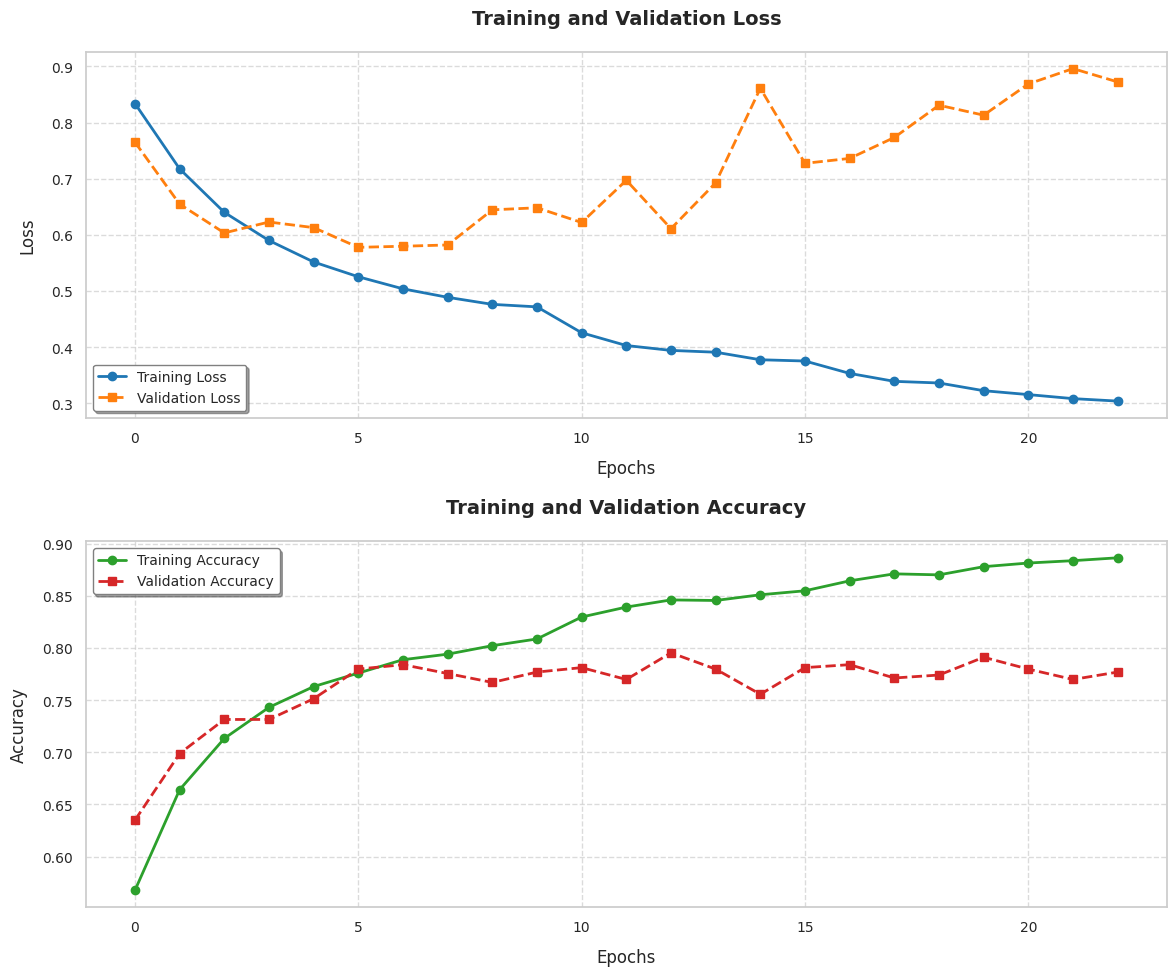

In [160]:
plot_history(history)

In [161]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/modeli_klasifikacija'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_chrononet.keras')
model.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_chrononet.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history.history, file)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8005 - loss: 0.6153
Test Loss: 0.6233211159706116
Test Accuracy: 0.7911931872367859


In [162]:
def build_cnn_transformer(input_shape, num_heads=4, dff=128, num_transformer_blocks=2, learning_rate=1e-4,
                          dropout_rate=0.3, l1=1e-6, l2=1e-5, kernel_initializer='he_normal'):

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv1D(
        64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    )(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    x = tf.keras.layers.Conv1D(
        128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    )(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    for _ in range(num_transformer_blocks):
        # Multi-Head Attention
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=x.shape[-1]
        )(x, x)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-Forward nn
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                dff, activation='relu', kernel_initializer=kernel_initializer,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
            ),
            tf.keras.layers.Dense(
                x.shape[-1], kernel_initializer=kernel_initializer,
                kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
            ),
        ])
        ffn_output = ffn(x)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)


    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    x = tf.keras.layers.Dense(
        128, activation='relu', kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(
        64, activation='relu', kernel_initializer=kernel_initializer,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Dense(
        1, activation='sigmoid', kernel_initializer='glorot_uniform'
    )(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



In [163]:
model = build_cnn_transformer(
    input_shape=(1260, 32),
    learning_rate=0.00029658199108801814,
    dropout_rate=0.2591410064953392,
    l1=2.227832881341042e-06,
    l2=0.0002902237380249683,
    num_transformer_blocks=4,
    dff=256,
    num_heads=6
)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_dataset_augment_20,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 108s 122ms/step - accuracy: 0.5199 - loss: 1.7877 - val_accuracy: 0.6051 - val_loss: 1.4466 - learning_rate: 2.9658e-04
Epoch 2/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.6342 - loss: 1.3271 - val_accuracy: 0.7273 - val_loss: 1.1360 - learning_rate: 2.9658e-04
Epoch 3/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.7178 - loss: 1.0240 - val_accuracy: 0.7557 - val_loss: 1.0034 - learning_rate: 2.9658e-04
Epoch 4/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.7600 - loss: 0.8441 - val_accuracy: 0.7884 - val_loss: 0.8483 - learning_rate: 2.9658e-04
Epoch 5/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.7844 - loss: 0.7266 - val_accuracy: 0.8011 - val_loss: 0.7916 - learning_rate: 2.9658e-04
Epoch 6/100
580/580 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.7971 - loss: 0.6525 - val_accuracy: 0.8239 - val_loss: 0.7121 - learning_rate: 2.9658e-04
Epoch 7/100
580/580 ━━━━━━━━━━━━━━━━━━━

In [164]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

save_dir = '/content/drive/My Drive/EEG/models/modeli_klasifikacija'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'model_customizable_transformer.keras')
model.save(model_path)

history_path = os.path.join(save_dir, 'history_model_customizable_transformer.pkl')
with open(history_path, "wb") as file:
    pickle.dump(history.history, file)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8624 - loss: 0.7684
Test Loss: 0.7719091176986694
Test Accuracy: 0.8622159361839294


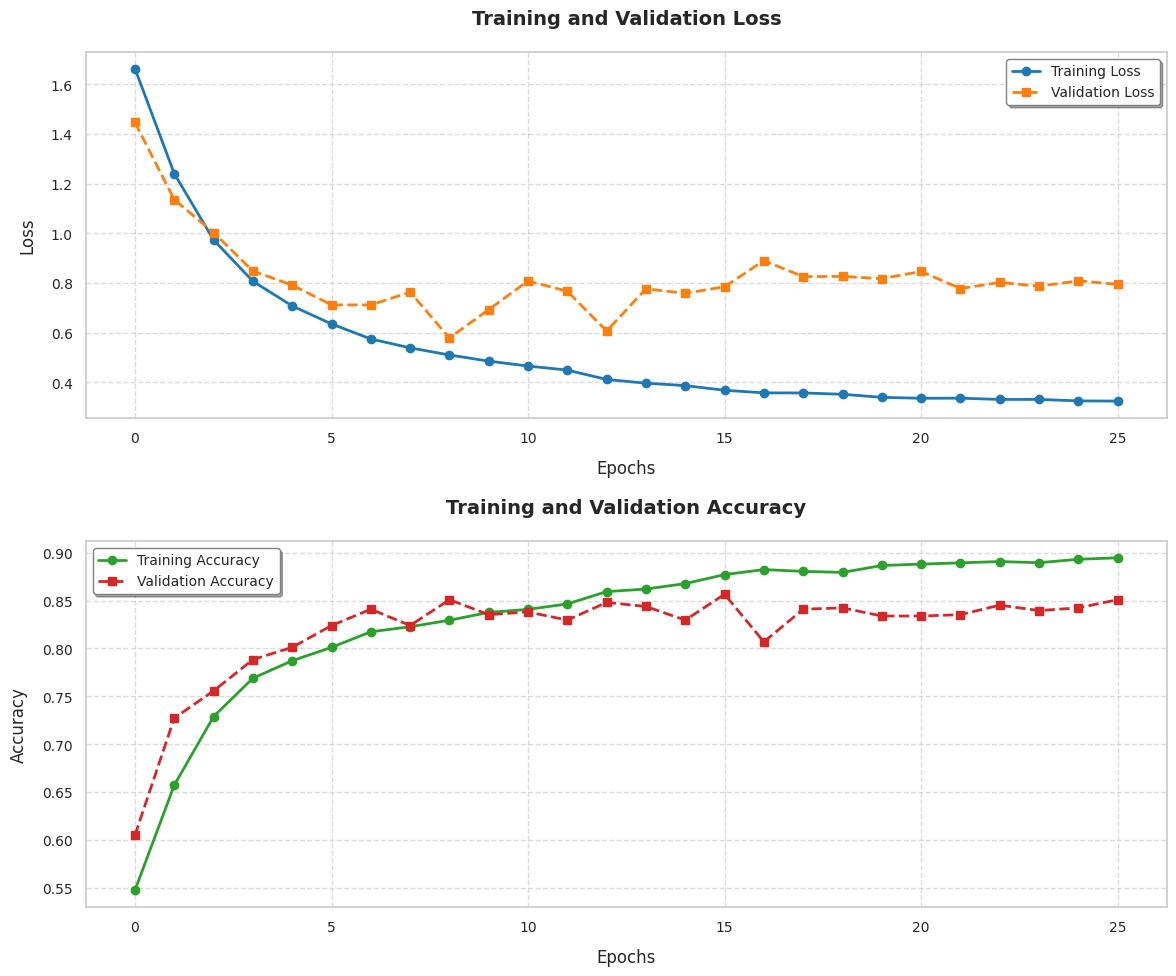

In [165]:
plot_history(history)

EVALUACIJA MODELOV

In [166]:
import pickle
save_dir = '/content/drive/My Drive/EEG/models/modeli_klasifikacija'


history_files = {
    "cnn": os.path.join(save_dir, 'history_model_customizable_1d_cnn_main.pkl'),
    "chrononet": os.path.join(save_dir, 'history_model_customizable_chrononet.pkl'),
    "transformer": os.path.join(save_dir, 'history_model_customizable_transformer.pkl'),
}

loaded_histories = {}

for model_name, file_path in history_files.items():
    try:
        with open(file_path, "rb") as file:
            loaded_histories[model_name] = pickle.load(file)
        print(f"History for {model_name} loaded successfully.")
    except Exception as e:
        print(f"Failed to load history for {model_name}: {e}")


History for cnn loaded successfully.
History for chrononet loaded successfully.
History for transformer loaded successfully.


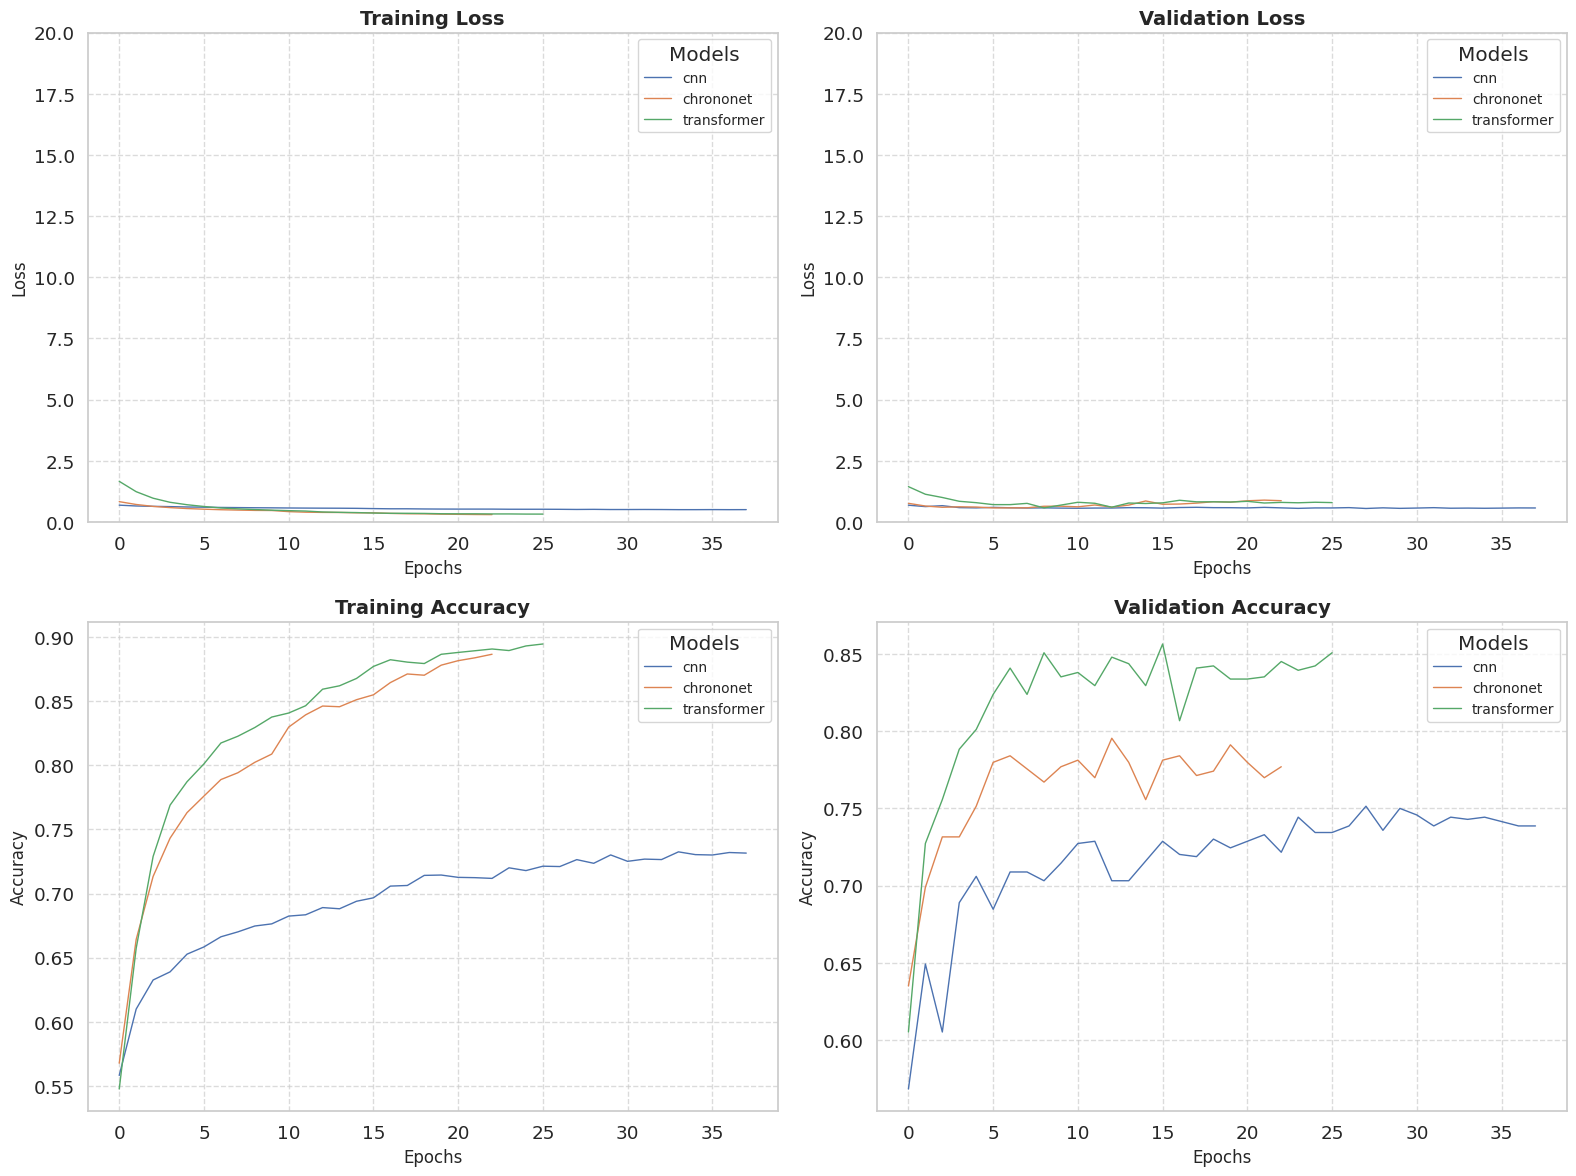

In [172]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

def plot_all_metrics_together(histories):
    metrics = ["loss", "val_loss", "accuracy", "val_accuracy"]
    titles = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]
    ylabels = ["Loss", "Loss", "Accuracy", "Accuracy"]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for ax, metric, title, ylabel in zip(axes, metrics, titles, ylabels):
        for name, history in histories.items():
            if metric in history:
                ax.plot(history[metric], label=f"{name}", linewidth=1)
        ax.set_title(title, fontweight='bold', fontsize=14)
        ax.set_xlabel("Epochs", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)

        if metric in ["loss", "val_loss"]:
            ax.set_ylim(0, 20)
        ax.legend(loc="best", fontsize=10, title="Models")
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_all_metrics_together(loaded_histories)


In [174]:

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

save_dir = '/content/drive/My Drive/EEG/models/modeli_klasifikacija'

model_paths = {
    "cnn": os.path.join(save_dir, 'model_customizable_1d_cnn_main.keras'),
    "chrononet": os.path.join(save_dir, 'model_customizable_chrononet.keras'),
    "transformer": os.path.join(save_dir, 'model_customizable_transformer.keras'),
}

results = {}
classification_reports = {}

target_names = ["Not Drinking Coffee", "Drinking Coffee"]

for model_name, model_path in model_paths.items():
    try:
        model = load_model(model_path)

        y_true = []
        for _, label_batch in test_dataset:
            y_true.extend(label_batch.numpy())
        y_true = np.array(y_true)

        y_pred = model.predict(test_dataset, verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()

        loss, accuracy = model.evaluate(test_dataset, verbose=0)
        num_params = model.count_params()
        aic = 2 * num_params + 2 * loss

        precision = precision_score(y_true, y_pred_classes)
        recall = recall_score(y_true, y_pred_classes)
        f1 = f1_score(y_true, y_pred_classes)

        results[model_name] = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "num_params": num_params,
            "aic": aic
        }

        classification_reports[model_name] = classification_report(
            y_true, y_pred_classes, target_names=target_names, output_dict=True
        )

        print(f"{model_name}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}, AIC = {aic:.2f}")

    except Exception as e:
        print(f"Failed to process {model_name}: {e}")


cnn: Loss = 0.5468, Accuracy = 0.7543, Precision = 0.5053, Recall = 0.5395, F1-Score = 0.5219, AIC = 96899.09
Counter({1: 354, 0: 350})
ROC AUC: 0.5238
chrononet: Loss = 0.6105, Accuracy = 0.7955, Precision = 0.5058, Recall = 0.4901, F1-Score = 0.4978, AIC = 674499.22
Counter({1: 353, 0: 351})
ROC AUC: 0.4790
transformer: Loss = 0.7843, Accuracy = 0.8580, Precision = 0.5235, Recall = 0.5086, F1-Score = 0.5159, AIC = 3809667.57
Counter({0: 354, 1: 350})
ROC AUC: 0.5145


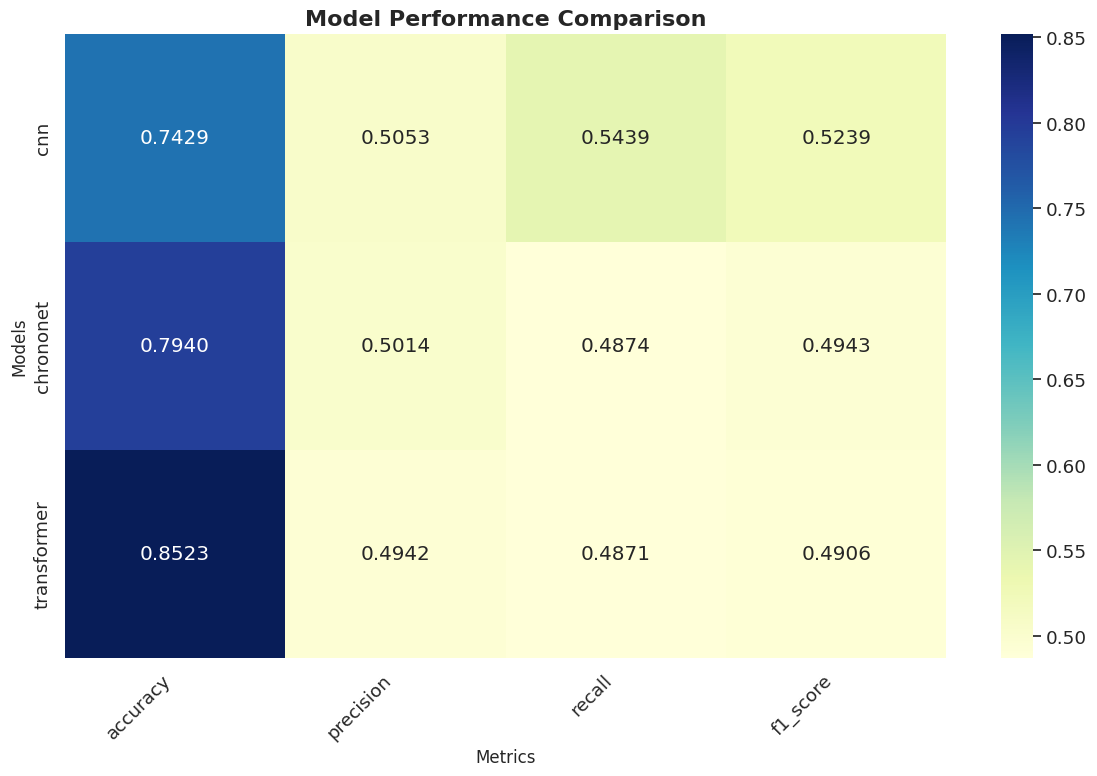

In [169]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

df = pd.DataFrame(results).T

metrics_without_aic = ['accuracy', 'precision', 'recall', 'f1_score']

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[metrics_without_aic], annot=True, fmt='.4f', cmap='YlGnBu', ax=ax)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


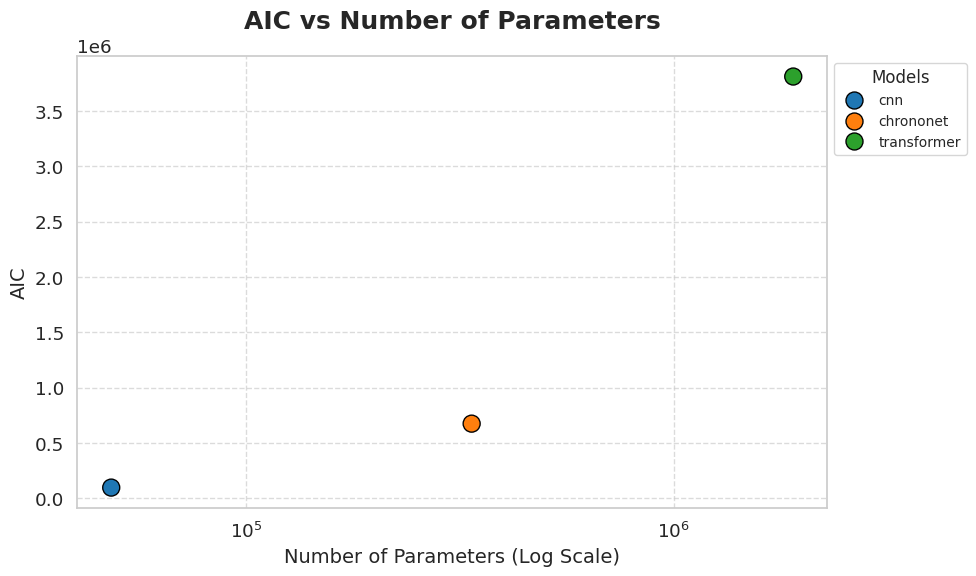

In [170]:
if 'num_params' in df.columns and 'aic' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x='num_params',
        y='aic',
        hue=df.index,
        palette='tab10',
        s=150,
        edgecolor='black'
    )
    plt.title('AIC vs Number of Parameters', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of Parameters (Log Scale)', fontsize=14)
    plt.ylabel('AIC', fontsize=14)
    plt.xscale('log')
    plt.legend(
        title='Models',
        fontsize=10,
        title_fontsize=12,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'num_params' and 'aic' are missing in the data.")